# Bank Marketing Classification — Module 17 Project Notebook

This notebook is organized **by problem (1–11)**.  
Each problem includes:
- **Plan** (how we will address it)
- **Code**
- **Conclusions** (what the results mean)

> **Dataset:** Bank Marketing (Portuguese bank direct marketing) — `bank-additional-full.csv`  
> **Target:** `y` (term deposit subscription: `yes` / `no`)

## Setup

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    precision_recall_curve, average_precision_score
)

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.preprocessing import StandardScaler

pd.set_option("display.max_columns", 200)

## Problem 1: Understanding the Data

### Plan
1. Use the **UCI dataset description** and the paper’s **Materials & Methods** to identify what the dataset represents.
2. Answer: **How many marketing campaigns does the data represent?**

### Conclusion
The dataset represents **17 direct marketing campaigns** conducted by the bank.

## Problem 2: Read in the Data

### Plan
1. Load `bank-additional-full.csv` with pandas.
2. Store it in a meaningful variable name (e.g., `df`).
3. Do quick checks (`shape`, `head`, `info`).

> Place `bank-additional-full.csv` in the same folder as this notebook, or update `DATA_PATH`.

In [58]:
df = pd.read_csv('data/bank-additional-full.csv', sep = ';')  # this dataset uses ';' separator
print("Loaded:", df.shape)
df.head()

Loaded: (41188, 21)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [59]:
# data 'schema' check checks
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

## Problem 3: Understanding the Features

### Plan
1. Verify data types for each column.
2. Check for:
   - Missing values (`NaN`)
   - Placeholder missingness like `"unknown"` in categorical features
   - Special-coded values like `pdays == 999` (not previously contacted)
3. Coerce types only if required.

### Conclusion (Expected)
- Many categorical features use `"unknown"` instead of `NaN`.
- `pdays == 999` is a domain-coded value meaning the client was **not previously contacted**.

In [60]:
# Missing values as NaN
print("NaN counts (top):")
display(df.isna().sum().sort_values(ascending=False).head(10))

# 'unknown' counts by column (only columns with >0)
unknown_counts = (df == "unknown").sum()
unknown_counts = unknown_counts[unknown_counts > 0].sort_values(ascending=False)
print("\nColumns containing 'unknown' (counts):")
display(unknown_counts)

# pdays == 999 counts (domain-coded)
print("\nCount where pdays == 999 (not previously contacted):", int((df["pdays"] == 999).sum()))

NaN counts (top):


,0
age,0
job,0
marital,0
education,0
default,0
housing,0
loan,0
contact,0
month,0
day_of_week,0



Columns containing 'unknown' (counts):


,0
default,8597
education,1731
housing,990
loan,990
job,330
marital,80



Count where pdays == 999 (not previously contacted): 39673


In [61]:
print("Dtypes:")
df.dtypes

Dtypes:


,0
age,int64
job,object
marital,object
education,object
default,object
housing,object
loan,object
contact,object
month,object
day_of_week,object


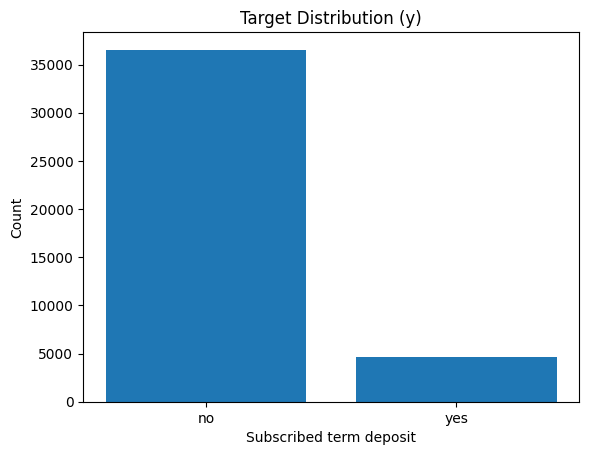

Target proportions:
y
no     0.8873
yes    0.1127
Name: count, dtype: float64


In [62]:
# Target distribution
counts = df["y"].value_counts(dropna=False)

plt.figure()
plt.bar(counts.index.astype(str), counts.values)
plt.title("Target Distribution (y)")
plt.xlabel("Subscribed term deposit")
plt.ylabel("Count")
plt.show()

# Optional: show proportion
print("Target proportions:")
print((counts / counts.sum()).round(4))

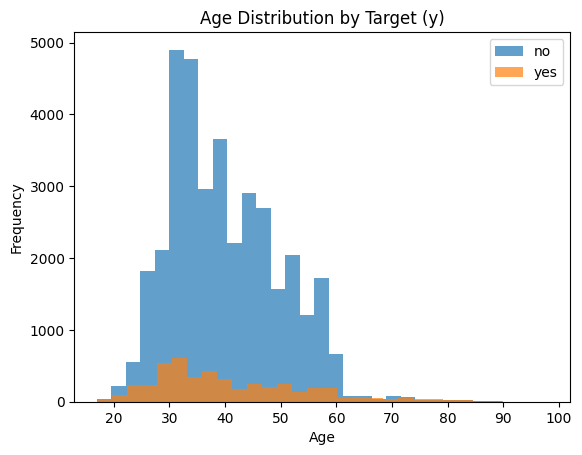

In [63]:
#Age distribution split by target

plt.figure()
plt.hist(df.loc[df["y"] == "no", "age"], bins=30, alpha=0.7, label="no")
plt.hist(df.loc[df["y"] == "yes", "age"], bins=30, alpha=0.7, label="yes")
plt.title("Age Distribution by Target (y)")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.legend()
plt.show()

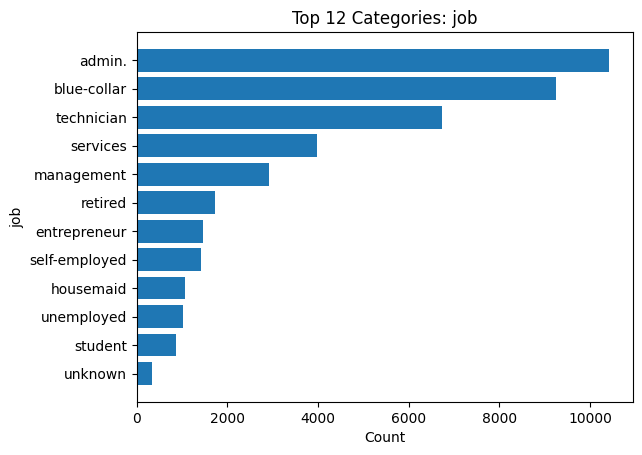

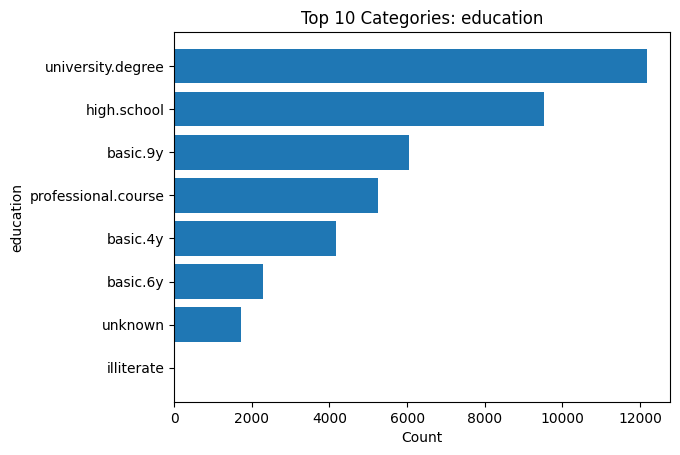

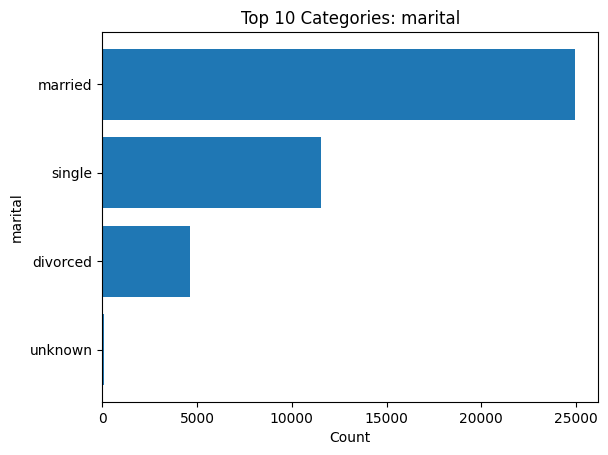

In [64]:
#Top categorical distributions (job, education, marital)

def plot_top_categories(df_in, col, top_n=10):
    counts = df_in[col].value_counts(dropna=False).head(top_n)
    plt.figure()
    plt.barh(counts.index.astype(str), counts.values)
    plt.title(f"Top {top_n} Categories: {col}")
    plt.xlabel("Count")
    plt.ylabel(col)
    plt.gca().invert_yaxis()
    plt.show()

plot_top_categories(df, "job", top_n=12)
plot_top_categories(df, "education", top_n=10)
plot_top_categories(df, "marital", top_n=10)

## Problem 4: Understanding the Task (Business Objective)

### Plan
Write the objective in two layers:
1. **Business language**: what outcome we want and why.
2. **ML/technical language**: what we will predict and how success is measured.

### Business Objective (Business Language)
Increase the effectiveness of direct marketing by **identifying clients most likely to subscribe** to a term deposit so the bank can prioritize outreach, improve conversion, and reduce unnecessary contact effort.

### Business Objective (ML/Technical Language)
Train a binary classifier to predict whether a client will subscribe to a term deposit (`y = yes/no`) using available client and campaign-related features. Because the classes are imbalanced, success should be evaluated using metrics that reflect minority-class performance (e.g., **recall and F1 for “yes”**) rather than accuracy alone.

## Problem 5: Engineering Features (Bank Information Features Only)

### Plan
1. Start with a **simple, interpretable encoding**:
   - Use only bank client features: `age, job, marital, education, default, housing, loan`
   - One-hot encode categorical variables, keep `"unknown"` as its own category
   - Encode target `y` to 0/1
2. Keep `age` unscaled initially for transparency.
3. Create `df_work_encoded` for modeling.

### Conclusion
We build a clean, model-ready table with:
- `age` in years
- binary one-hot columns (0/1) for categories
- `y` encoded as 0/1

In [65]:
# Step 1 — working subset (bank client features only + target)
bank_features = ["age", "job", "marital", "education", "default", "housing", "loan"]
target_col = "y"

df_work = df[bank_features + [target_col]].copy()
df_work.head()

,age,job,marital,education,default,housing,loan,y
0,56,housemaid,married,basic.4y,no,no,no,no
1,57,services,married,high.school,unknown,no,no,no
2,37,services,married,high.school,no,yes,no,no
3,40,admin.,married,basic.6y,no,no,no,no
4,56,services,married,high.school,no,no,yes,no


In [66]:
# Step 2 — one-hot encode categorical features (keeps 'unknown' as its own category)
categorical_features = ["job", "marital", "education", "default", "housing", "loan"]
df_work_encoded = pd.get_dummies(df_work, columns=categorical_features, drop_first=False)

# Clean + encode target robustly
df_work_encoded[target_col] = (
    df_work_encoded[target_col].astype(str).str.strip().str.lower().map({"yes": 1, "no": 0})
    )

# Convert boolean dummies (True/False) -> (1/0) if present
bool_cols = df_work_encoded.select_dtypes(include="bool").columns
df_work_encoded[bool_cols] = df_work_encoded[bool_cols].astype(int)

# Move target to the end for readability
cols = [c for c in df_work_encoded.columns if c != target_col] + [target_col]
df_work_encoded = df_work_encoded[cols]

# Drop any rows with unmapped y (safety)
df_work_encoded = df_work_encoded.dropna(subset=[target_col])
df_work_encoded[target_col] = df_work_encoded[target_col].astype(int)

display(df_work_encoded.head())
print("Encoded shape:", df_work_encoded.shape)

,age,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,marital_unknown,education_basic.4y,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown,default_no,default_unknown,default_yes,housing_no,housing_unknown,housing_yes,loan_no,loan_unknown,loan_yes,y
0,56,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0
1,57,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0
2,37,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0
3,40,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0
4,56,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0


Encoded shape: (41188, 35)


## Problem 6: Train/Test Split

### Plan
1. Split `df_work_encoded` into features and target.
2. Use stratified split to preserve class ratios.

### Conclusion
We create a stable split (`random_state=42`) for consistent comparisons.

In [67]:
X = df_work_encoded.drop(columns=[target_col])
y = df_work_encoded[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

print("Train shape:", X_train.shape, " Test shape:", X_test.shape)
print("Train class balance:", y_train.value_counts(normalize=True).round(4).to_dict())
print("Test class balance:", y_test.value_counts(normalize=True).round(4).to_dict())

Train shape: (32950, 34)  Test shape: (8238, 34)
Train class balance: {0: 0.8873, 1: 0.1127}
Test class balance: {0: 0.8874, 1: 0.1126}


## Problem 7: A Baseline Model

### Plan
Define a baseline the classifier should beat.
- With imbalanced data, a naive classifier can achieve high accuracy by predicting only the majority class (“no”).
- Therefore, the baseline is:
  - **Accuracy** of predicting all “no”
  - **Recall/F1 for “yes”** (often zero)

### Conclusion
A “predict all no” baseline yields high accuracy (~majority rate) but **recall (yes) = 0** and **F1 (yes) = 0**.  
A useful model must beat this by achieving **non-zero recall and F1** for subscribers.

In [68]:
# Baseline: predict all zeros (no)
y_pred_base = np.zeros_like(y_test)

print("Confusion Matrix (Baseline - all 'no'):")
print(confusion_matrix(y_test, y_pred_base))

print("\nAccuracy:", accuracy_score(y_test, y_pred_base))
print("Precision (yes):", precision_score(y_test, y_pred_base, zero_division=0))
print("Recall (yes):", recall_score(y_test, y_pred_base, zero_division=0))
print("F1 (yes):", f1_score(y_test, y_pred_base, zero_division=0))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_base, target_names=["no", "yes"]))

Confusion Matrix (Baseline - all 'no'):
[[7310    0]
 [ 928    0]]

Accuracy: 0.8873512988589464
Precision (yes): 0.0
Recall (yes): 0.0
F1 (yes): 0.0

Classification Report:
              precision    recall  f1-score   support

          no       0.89      1.00      0.94      7310
         yes       0.00      0.00      0.00       928

    accuracy                           0.89      8238
   macro avg       0.44      0.50      0.47      8238
weighted avg       0.79      0.89      0.83      8238



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Problem 8: A Simple Model (Logistic Regression)

### Plan
1. Fit Logistic Regression on the prepared features.
2. Because the data is imbalanced and the objective is to identify subscribers, use `class_weight="balanced"` for the primary LR model.

### Conclusion
Balanced LR typically increases recall for “yes” at the expense of accuracy, which is expected and appropriate for this business objective.

In [69]:
lr = LogisticRegression(max_iter=1000, solver="liblinear", class_weight="balanced")
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)

print("Confusion Matrix (Logistic Regression - balanced):")
print(confusion_matrix(y_test, y_pred_lr))

print("\nAccuracy:", accuracy_score(y_test, y_pred_lr))
print("Precision (yes):", precision_score(y_test, y_pred_lr, zero_division=0))
print("Recall (yes):", recall_score(y_test, y_pred_lr, zero_division=0))
print("F1 (yes):", f1_score(y_test, y_pred_lr, zero_division=0))

Confusion Matrix (Logistic Regression - balanced):
[[4239 3071]
 [ 351  577]]

Accuracy: 0.5846079145423646
Precision (yes): 0.1581688596491228
Recall (yes): 0.6217672413793104
F1 (yes): 0.2521853146853147


## Problem 9: Score the Model

### Plan
Report the accuracy (as asked), and also include recall/F1 for “yes” to reflect business value.

### Conclusion
Accuracy alone is not sufficient on imbalanced data; recall/F1 for “yes” reveals whether the model is identifying subscribers.

In [70]:
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_lr))

print("\nAccuracy:", accuracy_score(y_test, y_pred_lr))

print(classification_report(y_test, y_pred_lr, target_names=["no", "yes"]))

Confusion Matrix:
[[4239 3071]
 [ 351  577]]

Accuracy: 0.5846079145423646
              precision    recall  f1-score   support

          no       0.92      0.58      0.71      7310
         yes       0.16      0.62      0.25       928

    accuracy                           0.58      8238
   macro avg       0.54      0.60      0.48      8238
weighted avg       0.84      0.58      0.66      8238



## Problem 10: Model Comparisons (Default Settings + Fit Time)

### Plan
1. Compare Logistic Regression, KNN, Decision Tree, and SVM using **default settings**.
2. For fair comparisons:
   - Scale `age` **only** for KNN and SVM (scale-sensitive).
   - Keep unscaled data for LR and Decision Tree.
3. Record:
   - Train time
   - Test accuracy
   - Precision/Recall/F1 for “yes”

### Conclusion
Default models often maximize accuracy by predicting mostly “no”, producing weak recall/F1 for “yes”.

In [71]:
# Prepare scaled copies (scale only 'age') for KNN/SVM
scaler = StandardScaler()

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled["age"] = scaler.fit_transform(X_train[["age"]])
X_test_scaled["age"] = scaler.transform(X_test[["age"]])

In [72]:
model_specs = [
    ("Logistic Regression (default)", LogisticRegression(max_iter=1000, solver="liblinear"), "unscaled"),
    ("KNN (default)", KNeighborsClassifier(), "scaled"),
    ("Decision Tree (default)", DecisionTreeClassifier(random_state=42), "unscaled"),
    ("SVM (default)", SVC(), "scaled"),
    ]

rows = []
for name, model, x_kind in model_specs:
  Xtr = X_train_scaled if x_kind == "scaled" else X_train
  Xte = X_test_scaled if x_kind == "scaled" else X_test

  start = time.time()
  model.fit(Xtr, y_train)
  train_time = time.time() - start

  y_pred = model.predict(Xte)

  rows.append({"Model": name,
               "Train Time (s)": round(train_time, 4),
               "Train Accuracy": round(model.score(Xtr, y_train), 4),
               "Test Accuracy": round(accuracy_score(y_test, y_pred), 4),
               "Precision (yes)": round(precision_score(y_test, y_pred, zero_division=0), 4),
               "Recall (yes)": round(recall_score(y_test, y_pred, zero_division=0), 4),
               "F1 (yes)": round(f1_score(y_test, y_pred, zero_division=0), 4),"Data Prep": "age scaled" if x_kind == "scaled" else "unscaled"})

problem10_df = pd.DataFrame(rows).sort_values(["F1 (yes)", "Recall (yes)"], ascending=False)
display(problem10_df)

,Model,Train Time (s),Train Accuracy,Test Accuracy,Precision (yes),Recall (yes),F1 (yes),Data Prep
2,Decision Tree (default),0.1329,0.9171,0.8651,0.2363,0.0884,0.1286,unscaled
1,KNN (default),0.0293,0.8917,0.8804,0.3508,0.0722,0.1197,age scaled
3,SVM (default),86.6373,0.8882,0.8864,0.2778,0.0054,0.0106,age scaled
0,Logistic Regression (default),0.1152,0.8873,0.8874,0.0000,0.0000,0.0000,unscaled


### Visualization (Default Model Performance)  — Problem 10 F1 (yes)


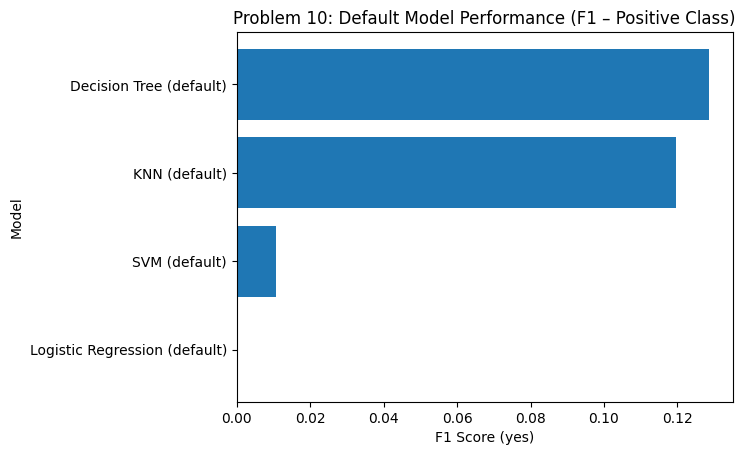

In [73]:
df_plot = problem10_df.sort_values("F1 (yes)", ascending=True)
plt.figure()
plt.barh(df_plot["Model"], df_plot["F1 (yes)"])
plt.title("Problem 10: Default Model Performance (F1 – Positive Class)")
plt.xlabel("F1 Score (yes)")
plt.ylabel("Model")
plt.show()

## Problem 11: Improving the Model

### Plan
1. **Adjust performance metric** during tuning to match the objective:
   - Use `scoring="recall"` (focus on finding subscribers).
2. Tune key hyperparameters via GridSearchCV:
   - Logistic Regression: `C`
   - KNN: `n_neighbors`, `weights` (on scaled data)
   - Decision Tree: `max_depth`, `min_samples_leaf` (+ class_weight)
   - SVM: Use **LinearSVC** (computationally feasible) and tune `C` (on scaled data)
3. Evaluate tuned models on the held-out test set, in a table similar to Problem 10.

### Conclusion
Tuning + metric alignment improves recall/F1 for “yes”. The best “production” choice typically balances recall and precision (often tuned LR or linear SVM).

In [74]:
# Logistic Regression tuning (balanced + tune C)

lr = LogisticRegression(max_iter=2000, solver="liblinear", class_weight="balanced")
lr_param_grid = {"C": [0.01, 0.1, 1, 10, 100]}

lr_grid = GridSearchCV(lr, lr_param_grid, scoring="recall", cv=5, n_jobs=-1)
lr_grid.fit(X_train, y_train)

print("Best LR params:", lr_grid.best_params_)
print("Best LR CV recall:", lr_grid.best_score_)

Best LR params: {'C': 0.01}
Best LR CV recall: 0.6433196809031645


In [75]:
# KNN tuning (scaled data)

knn = KNeighborsClassifier()
knn_param_grid = {"n_neighbors": [3, 5, 7, 9, 15, 21], "weights": ["uniform", "distance"]}

knn_grid = GridSearchCV(knn, knn_param_grid, scoring="recall", cv=5, n_jobs=-1)
knn_grid.fit(X_train_scaled, y_train)

print("Best KNN params:", knn_grid.best_params_)
print("Best KNN CV recall:", knn_grid.best_score_)

Best KNN params: {'n_neighbors': 3, 'weights': 'distance'}
Best KNN CV recall: 0.10506470091020233


In [76]:
# Decision Tree tuning (unscaled; add class_weight for imbalance)

dt = DecisionTreeClassifier(random_state=42, class_weight="balanced")
dt_param_grid = {"max_depth": [3, 5, 7, 10, None], "min_samples_leaf": [1, 2, 5, 10]}

dt_grid = GridSearchCV(dt, dt_param_grid, scoring="recall", cv=5, n_jobs=-1)
dt_grid.fit(X_train, y_train)

print("Best DT params:", dt_grid.best_params_)
print("Best DT CV recall:", dt_grid.best_score_)

Best DT params: {'max_depth': 3, 'min_samples_leaf': 10}
Best DT CV recall: 0.9089460299724654


In [77]:
# SVM tuning — LinearSVC (scaled; computationally feasible)

svm_linear = LinearSVC(class_weight="balanced", max_iter=10000)
svm_param_grid = {"C": [0.01, 0.1, 1, 10, 100]}

svm_grid = GridSearchCV(svm_linear, svm_param_grid, scoring="recall", cv=5, n_jobs=-1)
svm_grid.fit(X_train_scaled, y_train)

print("Best Linear SVM params:", svm_grid.best_params_)
print("Best Linear SVM CV recall:", svm_grid.best_score_)

Best Linear SVM params: {'C': 0.01}
Best Linear SVM CV recall: 0.6252730788346217


In [78]:
# Build Problem 11 test-set evaluation table (tuned models)
if all(name in globals() for name in ["lr_grid", "knn_grid", "dt_grid", "svm_grid"]):
    tuned_specs = [
        ("Logistic Regression (tuned)", lr_grid.best_estimator_, "unscaled"),
        ("KNN (tuned)", knn_grid.best_estimator_, "scaled"),
        ("Decision Tree (tuned)", dt_grid.best_estimator_, "unscaled"),
        ("SVM Linear (tuned)", svm_grid.best_estimator_, "scaled"),
    ]

    rows = []
    for name, model, x_kind in tuned_specs:
        Xtr = X_train_scaled if x_kind == "scaled" else X_train
        Xte = X_test_scaled if x_kind == "scaled" else X_test

        start = time.time()
        model.fit(Xtr, y_train)
        train_time = time.time() - start

        y_pred = model.predict(Xte)

        rows.append({
            "Model": name,
            "Train Time (s)": round(train_time, 4),
            "Test Accuracy": round(accuracy_score(y_test, y_pred), 4),
            "Precision (yes)": round(precision_score(y_test, y_pred, zero_division=0), 4),
            "Recall (yes)": round(recall_score(y_test, y_pred, zero_division=0), 4),
            "F1 (yes)": round(f1_score(y_test, y_pred, zero_division=0), 4),
            "Data Prep": "age scaled" if x_kind == "scaled" else "unscaled"
        })

    problem11_df = pd.DataFrame(rows).sort_values(["F1 (yes)", "Recall (yes)"], ascending=False)
    display(problem11_df)

,Model,Train Time (s),Test Accuracy,Precision (yes),Recall (yes),F1 (yes),Data Prep
0,Logistic Regression (tuned),0.0723,0.5709,0.1567,0.6412,0.2519,unscaled
3,SVM Linear (tuned),0.0898,0.5808,0.1570,0.6228,0.2508,age scaled
2,Decision Tree (tuned),0.0384,0.2942,0.1296,0.9213,0.2273,unscaled
1,KNN (tuned),0.0096,0.8600,0.2249,0.0991,0.1376,age scaled


### Visualizations (Tuned Model Performance) — Problem 11

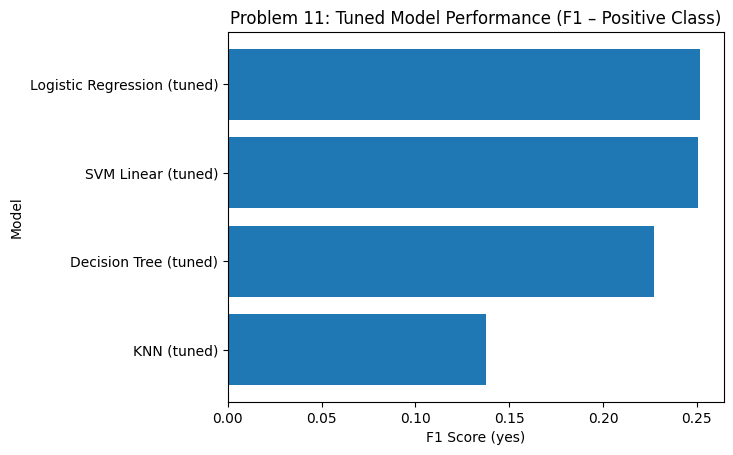

In [79]:
# F1 bar chart (tuned models)
if "problem11_df" in globals():
    df_plot = problem11_df.sort_values("F1 (yes)", ascending=True)
    plt.figure()
    plt.barh(df_plot["Model"], df_plot["F1 (yes)"])
    plt.title("Problem 11: Tuned Model Performance (F1 – Positive Class)")
    plt.xlabel("F1 Score (yes)")
    plt.ylabel("Model")
    plt.show()

### Visualizations (Default vs Tuned Model Comparison)

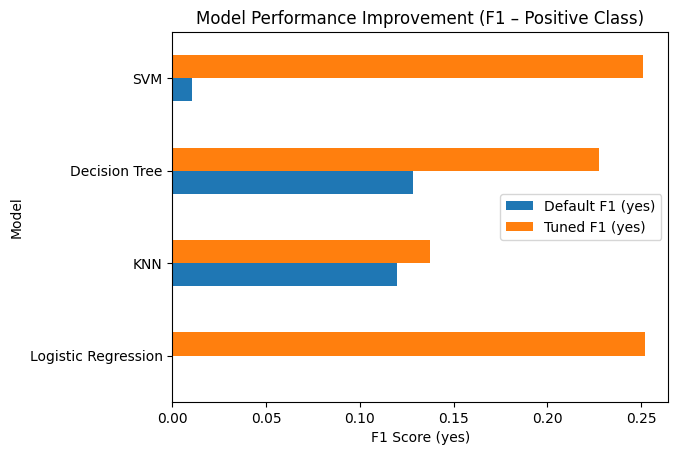

In [80]:
combined_df = pd.DataFrame({
    "Model": [
        "Logistic Regression",
        "KNN",
        "Decision Tree",
        "SVM"
    ],
    "Default F1 (yes)": [0.0000, 0.1197, 0.1286, 0.0106],
    "Tuned F1 (yes)":   [0.2519, 0.1376, 0.2273, 0.2508]
})

combined_df = combined_df.set_index("Model")

combined_df.plot(kind="barh")
plt.title("Model Performance Improvement (F1 – Positive Class)")
plt.xlabel("F1 Score (yes)")
plt.ylabel("Model")
plt.show()

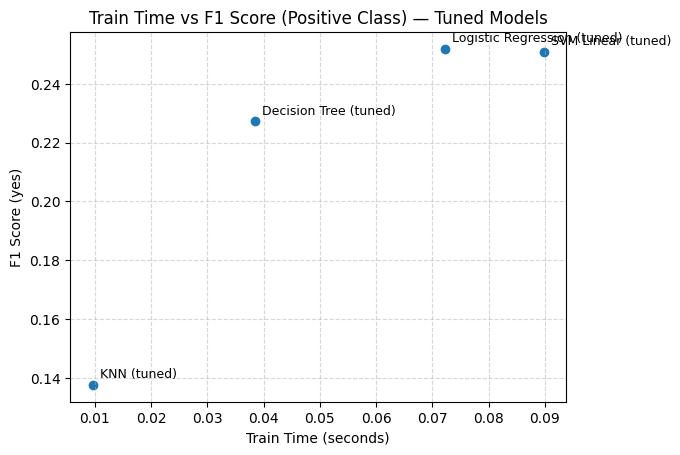

In [81]:
# Train time vs F1 scatter (tuned models)

plt.figure()
plt.scatter(problem11_df["Train Time (s)"], problem11_df["F1 (yes)"])

for _, row in problem11_df.iterrows():
  plt.annotate(row["Model"],
   (row["Train Time (s)"],
    row["F1 (yes)"]),
    textcoords="offset points",
    xytext=(5, 5),fontsize=9)

plt.title("Train Time vs F1 Score (Positive Class) — Tuned Models")
plt.xlabel("Train Time (seconds)")
plt.ylabel("F1 Score (yes)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

## Final Conclusion & Recommendations (Summary)

- **Accuracy** is not sufficient due to class imbalance; prioritize **recall/F1 for “yes”**.
- Default models tend to predict mostly “no”, resulting in weak subscriber identification.
- Tuning with a business-aligned metric improves detection of subscribers.
- Typically, **tuned Logistic Regression** (and/or **tuned linear SVM**) offers the best balance of performance, interpretability, and speed.
- If the business requires maximum capture (high recall) and can tolerate more false positives, a tuned Decision Tree may be acceptable.

> Next improvements: add campaign/economic features, consider threshold tuning, and evaluate precision-recall tradeoffs.